Import Libraries

In [3]:
import os
import gdown
import torch
import numpy as np
import seaborn as sns
import transformers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from sklearn import metrics

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW

%matplotlib inline


In [17]:
gdown.download('https://drive.google.com/uc?id=1q4U2gVY9tWEPdT6W-pdQpKmo152QqWLE', 'finance_train.csv', True)
gdown.download('https://drive.google.com/uc?id=1nIBqAsItwVEGVayYTgvybz7HeK0asom0', 'finance_test.csv', True)

def get_finance_train():
  df_train = pd.read_csv("finance_train.csv")
  return df_train
def get_finance_test():
  df_test = pd.read_csv("finance_test.csv")
  return df_test

LABEL_MAP = {0: "Negative", 1: "Neutral", 2: "Positive"}
NONE = 4 * [None]

RND_SEED = 2020

In [18]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print ("Train and Test Files Loaded as train.csv and test.csv")

Train and Test Files Loaded as train.csv and test.csv


Confusion Matrix Function

In [19]:
def plot_confusion_matrix(y_true,y_predicted):
  cm = metrics.confusion_matrix(y_true, y_predicted)
  print ("Plotting the Confusion Matrix")
  labels = ["Negative","Neutral","Positive"]
  df_cm = pd.DataFrame(cm,index =labels,columns = labels)
  fig = plt.figure(figsize=(14,12))
  res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
  plt.yticks([0.5,1.5,2.5], labels,va='center')
  plt.title('Confusion Matrix - TestData')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  plt.close()

Reading in the Datasets

In [20]:
df_train = get_finance_train()
df_test = get_finance_test()

In [61]:
sentences = df_train['Sentence'].values
labels = df_train['Label'].values

In [34]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case = True)

In [38]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0]))

[8285,
 5794,
 2243,
 2177,
 2003,
 2112,
 1997,
 2004,
 6873,
 1005,
 1055,
 3001,
 2407,
 1012]

In [59]:
sentences_with_special_tokens = []

for i in sentences:
  new_sentence = "[CLS] " + i + " [SEP]"
  sentences_with_special_tokens.append(new_sentence)


In [60]:
tokenized_texts = []

for i in sentences_with_special_tokens:
  tokenized_texts.append(tokenizer.tokenize(i))

In [42]:
input_ids = []

for i in tokenized_texts:
    input_ids.append(tokenizer.convert_tokens_to_ids(i))
    

In [56]:
input_ids = pad_sequences(input_ids,
                          maxlen=128, 
                          dtype="long",
                          truncating="post",
                          padding="post")

In [57]:
attention_masks = []

for item in input_ids:
  attention_masks.append([float(i > 0) for i in item])

In [63]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels, test_size=0.15, random_state = RND_SEED)

In [65]:
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.15, random_state = 42)

In [66]:
train_inputs = torch.tensor(np.array(X_train));
validation_inputs = torch.tensor(np.array(X_val));
train_masks = torch.tensor(np.array(train_masks));
validation_masks = torch.tensor(np.array(validation_masks));
train_labels = torch.tensor(np.array(y_train));
validation_labels = torch.tensor(np.array(y_val));

batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels);
train_sampler = RandomSampler(train_data); # Samples data randonly for training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size);
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels);
validation_sampler = SequentialSampler(validation_data); # Samples data sequentially
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size);

In [69]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
)

device = torch.device("cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [71]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4

In [75]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

training_loss = []
validation_loss = []
training_stats = []

for epoch_i in range(0, epochs):
    # Training
    print('Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training the model')
    # Reset the total loss for  epoch.
    total_train_loss = 0
    # Put the model into training mode.
    model.train()
    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 20 == 0 and not step == 0:
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}. '.format(step, len(train_dataloader)))

        # STEP 1 & 2: Unpack this training batch from our dataloader.
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # STEP 3
        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # STEP 4
        # Perform a forward pass (evaluate the model on this training batch).
        # It returns the loss (because we provided labels) and
        # the "logits"--the model outputs prior to activation.
        outputs = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # STEP 5
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # STEP 6
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # Validation
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("Evaluating on Validation Set")
    # Put the model in evaluation mode
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        #Step 1 and Step 2
        # Unpack this validation batch from our dataloader.

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)



    print("Validation Loss: {0:.2f}".format(avg_val_loss))


    training_loss.append(avg_train_loss)
    validation_loss.append(avg_val_loss)
    # Record all statistics from this epoch.

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy

        }
    )

print("Training complete!")

Epoch 1 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.58
Evaluating on Validation Set
Validation Accuracy: 0.79
Validation Loss: 0.47
Epoch 2 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.34
Evaluating on Validation Set
Validation Accuracy: 0.91
Validation Loss: 0.27
Epoch 3 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.17
Evaluating on Validation Set
Validation Accuracy: 0.91
Validation Loss: 0.26
Epoch 4 / 4 ========
Training the model
  Batch    20  of     55. 
  Batch    40  of     55. 
  Average training loss: 0.11
Evaluating on Validation Set
Validation Accuracy: 0.92
Validation Loss: 0.26
Training complete!


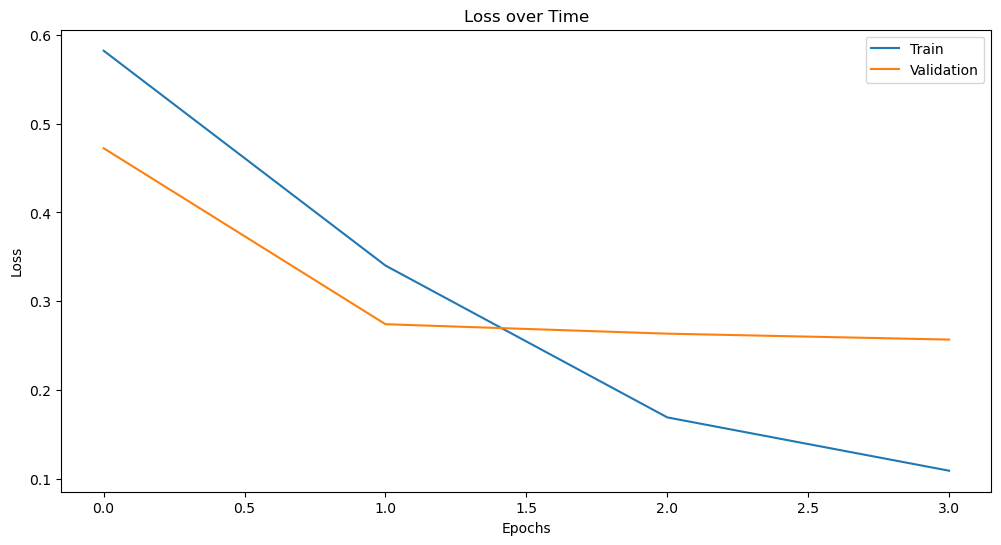

In [76]:
fig = plt.figure(figsize=(12,6))
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(training_loss, label = "Train")
plt.plot(validation_loss, label = "Validation")

plt.legend()
plt.show()

In [77]:
test_sentences = df_test['Sentence'].values
test_labels = df_test['Label'].values

In [78]:
test_input_ids, test_attention_masks = [], []

# Add Special Tokens
test_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in test_sentences]

# Tokenize sentences
tokenized_test_sentences = [tokenizer.tokenize(sent) for sent in test_sentences]

# Encode Tokens to Word IDs
test_input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_test_sentences]

# Pad the inputs
test_input_ids = pad_sequences(test_input_ids,
                               maxlen=128,
                               dtype="long",
                               truncating="post",
                               padding="post")

# Create Attention Masks
for sequence in test_input_ids:
  mask = [float(i>0) for i in sequence]
  test_attention_masks.append(mask)

In [79]:
batch_size = 32
test_input_ids = torch.tensor(test_input_ids)
test_attention_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)
prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Test Accuracy: 94.71%
Plotting the Confusion Matrix


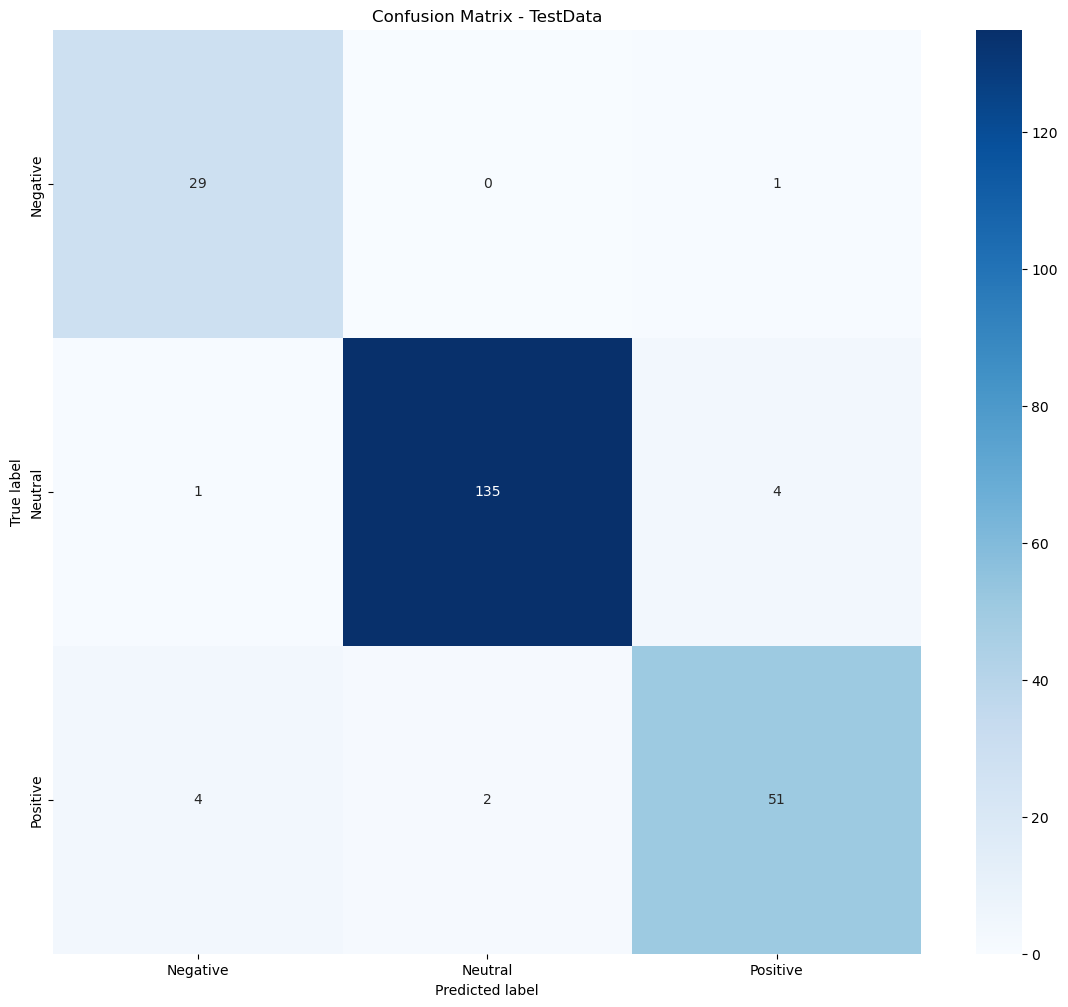

In [80]:
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

# Final tracking variables
y_logits, y_true, y_preds = [], [], []

# Gather logit predictions
for chunk in predictions:
  for logits in chunk:
    y_logits.append(logits)

# Gather true labels
for chunk in true_labels:
  for label in chunk:
    y_true.append(label)

# Gather real predictions
for logits in y_logits:
  y_preds.append(np.argmax(logits))

print ('Test Accuracy: {:.2%}'.format(metrics.accuracy_score(y_preds,y_true)))
plot_confusion_matrix(y_true,y_preds)
